In [1]:
import sys
import os

In [2]:
dirname = os.path.dirname('__file__')

In [3]:
sys.path.append(os.path.join(dirname, './modules'))

In [4]:
import pandas as pd
import requests
import re
import time
import data_processing_functions
import sklearn.metrics
import xgboost as xgb

from bs4 import BeautifulSoup as bs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB

C:\Users\dfeld\anaconda3\envs\NHL_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
df_salary = pd.read_csv(os.path.join(dirname, '../data/nhl_player_yearly_salaries.csv'), index_col=0)

In [6]:
df_stats = pd.read_csv(os.path.join(dirname, '../data/full_nhl_player_yearly_stats.csv'), index_col=0)

In [7]:
df_inflation = pd.read_csv(os.path.join(dirname, '../data/USA_inflation_macrotrends.net.csv'))

In [8]:
df = data_processing_functions.preprocessing_pipeline(df_stats, df_salary)

In [685]:
df_inflation

,year,inflation_rate,relative_inflation
0,1961,1.4580,1.000000
1,1962,1.0707,1.010707
2,1963,1.1988,1.022823
3,1964,1.2397,1.035503
4,1965,1.2789,1.048746
...,...,...,...
56,2017,1.2616,8.115196
57,2018,2.1301,8.288058
58,2019,2.4426,8.490502
59,2020,1.8122,8.644366


In [686]:
df_inflation = df_inflation.tail(16).reset_index(drop = True)

In [687]:
df_inflation.relative_inflation = df_inflation.relative_inflation/df_inflation.loc[0, 'relative_inflation']

In [688]:
df_inflation = df_inflation[['year', 'relative_inflation']]

In [689]:
df_inflation.columns = ['season', 'rel_inflation']

In [690]:
df = df.merge(df_inflation, on = 'season')

In [691]:
df_salary = df[df['contract_year'] == 1].reset_index(drop = True)

In [692]:
low_scorer_list = []
for i in range(len(df_salary)):
    if (
        df_salary.loc[i, 'games_played'] < 26
        and (
            df_salary.loc[i, 'goals_created_per_60_minutes'] == 0
#         or df_salary.loc[i, 'goals_per_60_minutes'] == 0
#         or df_salary.loc[i, 'assists_per_60_minutes'] == 0
        )
       ):
        low_scorer_list.append(i)
df_salary = df_salary.drop(low_scorer_list).reset_index(drop = True)

In [693]:
# df_salary.AAV /= df_salary.rel_inflation

In [694]:
df_salary.columns

Index(['season', 'first_name', 'last_name', 'player_code', 'age',
       'team_abbreviation', 'games_played', 'time_on_ice',
       'goals_per_60_minutes', 'goals_created_per_60_minutes',
       'assists_per_60_minutes', 'goals_per_60_minutes_1_seasons_ago',
       'goals_created_per_60_minutes_1_seasons_ago',
       'assists_per_60_minutes_1_seasons_ago',
       'goals_per_60_minutes_2_seasons_ago',
       'goals_created_per_60_minutes_2_seasons_ago',
       'assists_per_60_minutes_2_seasons_ago', 'AAV', 'contract_year',
       'rel_inflation'],
      dtype='object')

<AxesSubplot:>

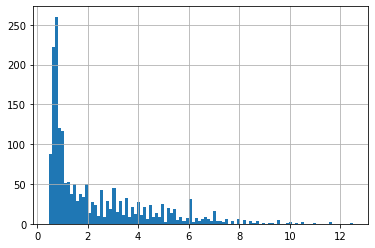

In [695]:
df_salary.AAV.hist(bins = 100)

In [696]:
df_salary_1_5 = df_salary[df_salary.AAV <= 1.5]
df_salary_4_25 = df_salary[(df_salary.AAV > 1.5) & (df_salary.AAV <= 4.25)]
df_salary_12_5 = df_salary[df_salary.AAV > 4.25]

In [697]:
print(df_salary_1_5.shape, df_salary_4_25.shape, df_salary_12_5.shape)

(993, 20) (559, 20) (308, 20)


In [698]:
df_salary = pd.concat([
    df_salary_1_5,
    df_salary_4_25,
    df_salary_4_25,
    df_salary_4_25,
    df_salary_12_5,
    df_salary_12_5,
    df_salary_12_5,
    df_salary_12_5,
    df_salary_12_5,
])

In [699]:
df_salary.AAV.quantile(q = 0.875)

6.25

In [724]:
feature_list = [
    'season',
    'age',
    'goals_created_per_60_minutes',
#     'goals_per_60_minutes',
#     'assists_per_60_minutes',
    'rel_inflation',
    'goals_created_per_60_minutes_1_seasons_ago',
    'goals_per_60_minutes_1_seasons_ago',
    'assists_per_60_minutes_1_seasons_ago',
    'goals_created_per_60_minutes_2_seasons_ago',
    'goals_per_60_minutes_2_seasons_ago',
    'assists_per_60_minutes_2_seasons_ago',
]

In [725]:
X = df_salary[feature_list].to_numpy()
y = df_salary.AAV.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=99)

In [726]:
X.shape

(4210, 10)

In [172]:
param_grid = {'kernel': ['poly'],
            'degree': [2,3,5],
            'tol': [0.001, 0.01, 0.1],
            'C': [0.1, 1.0, 10]}

In [173]:
gs = GridSearchCV(estimator=SVR(), param_grid=param_grid)

In [174]:
# gs.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1.0, 10], 'degree': [2, 3, 5],
                         'kernel': ['poly'], 'tol': [0.001, 0.01, 0.1]})

In [164]:
svm_reg = SVR()

In [175]:
gs.best_params_

{'C': 10, 'degree': 2, 'kernel': 'poly', 'tol': 0.1}

In [176]:
y_hat = gs.predict(X_test)

In [177]:
sklearn.metrics.mean_squared_error(y_test, y_hat)

3.3879347692989428

In [716]:
param_grid_xgb = {'n_estimators': [25, 50, 100], 'max_depth': [2,3,4]}
gs_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid_xgb)
gs_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                          

In [717]:
gs_xgb.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [718]:
y_hat_xgb = gs_xgb.predict(X_test)

In [719]:
sklearn.metrics.mean_squared_error(y_test, y_hat_xgb)

0.5591164872112672

In [732]:
param_grid_rf = {'n_estimators':[25, 50, 100,],
    'min_samples_split':[2,3, 4],
    'random_state': [99]}
gs_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_rf)
gs_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'min_samples_split': [2, 3, 4],
                         'n_estimators': [25, 50, 100], 'random_state': [99]})

In [733]:
gs_rf.best_params_

{'min_samples_split': 2, 'n_estimators': 100, 'random_state': 99}

In [734]:
y_hat_rf = gs_rf.predict(X_test)

In [735]:
sklearn.metrics.mean_squared_error(y_test, y_hat_rf)

0.29860618018347096

In [416]:
param_grid_lasso = {'alpha':[0.1, 1.0, 10]}
gs_lasso = GridSearchCV(Lasso(), param_grid= param_grid_lasso)
gs_lasso.fit(X_train, y_train)

GridSearchCV(estimator=Lasso(), param_grid={'alpha': [0.1, 1.0, 10]})

In [417]:
y_hat_lasso = gs_lasso.predict(X_test)

In [418]:
sklearn.metrics.mean_squared_error(y_test, y_hat_lasso)

1.948908575788692

In [387]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import keras.metrics

In [258]:
# def network():
network = models.Sequential()
network.add(layers.Dense(27, activation='relu', input_shape=(3,)))
network.add(layers.Dense(27, activation='relu'))
network.add(layers.Dense(1, activation='relu'))
network.compile(optimizer='adam',
                loss='mse',
                metrics=[keras.metrics.RootMeanSquaredError()])
#     return network

# estimator = KerasRegressor(build_fn = network, batch_size = 50, epochs = 100)
# cv_results = cross_validate(estimator, X, y, cv = 5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
network.fit(X_train, y_train, batch_size = 25, epochs = 100)

In [259]:
test_loss = network.evaluate(X_test, y_test)
print('test_acc:', test_acc, 'test_loss', test_loss)

12/12 [==============================] - 0s 1ms/step - loss: 3.2220 - root_mean_squared_error: 1.7950
test_acc: 1.7949984073638916 test_loss [3.2220191955566406, 1.7949984073638916]
